In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split as tts
from keras.layers import Dense, LSTM,Embedding, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
data = pd.read_csv("/content/gdrive/MyDrive/MTech-project/demo-dataset.csv")
data.head()

,target,tweet
0,0,Today in Selfcare beauty amp laughs Kung Fu Pa...
1,0,If this is your response to someone saying the...
2,0,Apparently you get a free pass just by mention...
3,0,When you will never again give birth to violen...
4,0,Aw man im outta pizza rolls


In [ ]:
category = list(data['target'].unique())
category

[0, 1]

In [ ]:
#del data['Unnamed: 0']

In [ ]:
data.head()

,target,tweet
0,0,Today in Selfcare beauty amp laughs Kung Fu Pa...
1,0,If this is your response to someone saying the...
2,0,Apparently you get a free pass just by mention...
3,0,When you will never again give birth to violen...
4,0,Aw man im outta pizza rolls


In [ ]:
import os, sys
import re
import string
import itertools

In [ ]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [ ]:
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

In [ ]:
def tweet_clean(text):
    text = re.sub(r'https?:/\/\S+', ' ', text) # remove urls
    text = re.sub(r'<([^>]*)>', ' ', text) # remove emojis
    text = re.sub(r'@\w+', ' ', text) # remove at mentions
    text = re.sub(r'#', '', text) # remove hashtag symbol
    text = re.sub(r'[0-9]+', ' ', text) # remove numbers
    text = replace_contractions(text)
    pattern = re.compile(r"[ \n\t]+")
    text = pattern.sub(" ", text)      
    text = "".join("".join(s)[:2] for _, s in itertools.groupby(text))    
    text = re.sub(r'[^A-Za-z0-9,?.!]+', ' ', text) # remove all symbols and punctuation except for . , ! and ?
    return text.strip()

In [ ]:
cleaned1=lambda x:tweet_clean(x)
data['tweet']=pd.DataFrame(data.tweet.apply(cleaned1))

In [ ]:
data.head()

,target,tweet
0,0,Today in Selfcare beauty amp laughs Kung Fu Pa...
1,0,If this is your response to someone saying the...
2,0,Apparently you get a free pass just by mention...
3,0,When you will never again give birth to violen...
4,0,Aw man im outta pizza rolls


In [ ]:
data.shape

(4245, 2)

In [ ]:
data.target.value_counts()

0    2357
1    1888
Name: target, dtype: int64

In [ ]:
max_features=5000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['tweet'].values)
X = tokenizer.texts_to_sequences(data['tweet'].values)
X = pad_sequences(X,maxlen=140)

In [ ]:
embed_dim = 128
lstm_out = 128

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 140, 128)          640000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 140, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 771,842
Trainable params: 771,842
Non-trainable params: 0
_________________________________________________________________
None


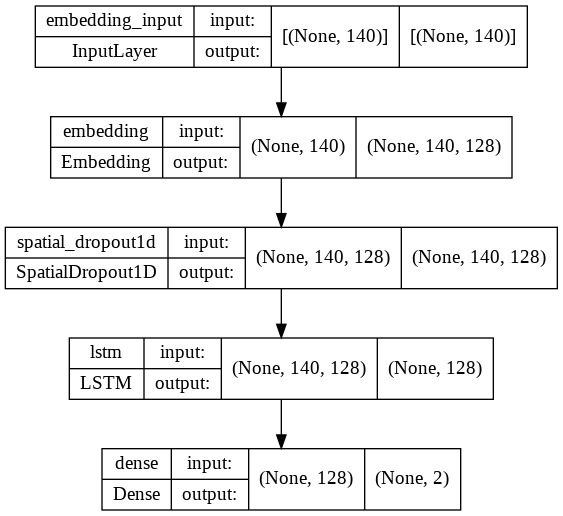

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
X.shape

(4245, 140)

In [ ]:
Y=pd.get_dummies(data['target']).values
X_train, X_test, Y_train, Y_test = tts(X,Y, test_size = 0.2, random_state = 42)

In [ ]:
batch_size = 40
history=model.fit(X_train, Y_train, epochs = 5, batch_size=batch_size,validation_data=(X_test,Y_test),verbose = True)

Epoch 1/5
85/85 [==============================] - 94s 980ms/step - loss: 0.4451 - accuracy: 0.8004 - val_loss: 0.1576 - val_accuracy: 0.9600
Epoch 2/5
85/85 [==============================] - 68s 796ms/step - loss: 0.0830 - accuracy: 0.9770 - val_loss: 0.0904 - val_accuracy: 0.9729
Epoch 3/5
85/85 [==============================] - 71s 835ms/step - loss: 0.0363 - accuracy: 0.9888 - val_loss: 0.0707 - val_accuracy: 0.9788
Epoch 4/5
85/85 [==============================] - 67s 789ms/step - loss: 0.0216 - accuracy: 0.9965 - val_loss: 0.0783 - val_accuracy: 0.9764
Epoch 5/5
85/85 [==============================] - 68s 800ms/step - loss: 0.0136 - accuracy: 0.9979 - val_loss: 0.0811 - val_accuracy: 0.9800


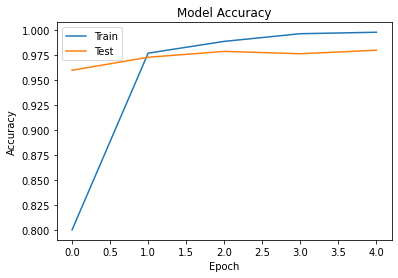

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

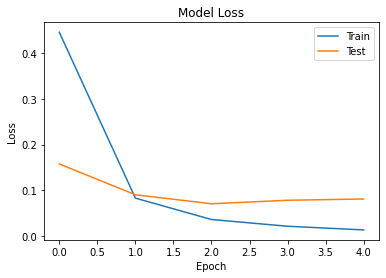

In [ ]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score

In [ ]:
len(Y_test.flatten())

1698

In [ ]:
import numpy as np
labels_pred = model.predict(X_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(Y_test.flatten(), labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 98.00%


In [ ]:
print(classification_report(Y_test.flatten(), labels_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       849
           1       0.98      0.98      0.98       849

    accuracy                           0.98      1698
   macro avg       0.98      0.98      0.98      1698
weighted avg       0.98      0.98      0.98      1698



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(Y_test.flatten(), labels_pred)
cm 

array([[832,  17],
       [ 17, 832]])

Text(33.0, 0.5, 'Truth')

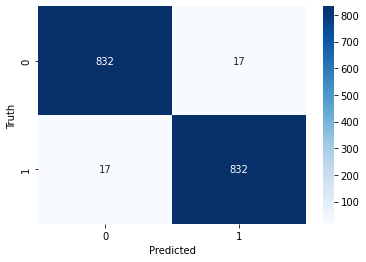

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
model.save('/content/gdrive/MyDrive/MTech-project/lstm/classifier.model')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/MTech-project/lstm/classifier.model/assets


In [ ]:
import pickle

# saving
with open('/content/gdrive/MyDrive/MTech-project/lstm/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import h5py


model.save('/content/gdrive/MyDrive/MTech-project/lstm/detector_model_finalX.pt')
model.save('/content/gdrive/MyDrive/MTech-project/lstm/detector_model_finalX.h5')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/MTech-project/lstm/detector_model_finalX.pt/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/MTech-project/lstm/detector_model_finalX.pt/assets


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/gdrive/MyDrive/MTech-project/lstm/classifier.model')


# Testing

In [ ]:
import pickle
# loading
with open('/content/gdrive/MyDrive/MTech-project/lstm/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
from keras.preprocessing.sequence import pad_sequences

In [ ]:
import os

import tensorflow as tf
from tensorflow import keras
model = tf.keras.models.load_model('/content/gdrive/MyDrive/MTech-project/lstm/detector_model_finalX.h5')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 140, 128)          640000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 140, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 771,842
Trainable params: 771,842
Non-trainable params: 0
_________________________________________________________________


In [ ]:
test = ['Very rewarding when a patient hugs you and tells you they feel great after changing the diet and daily habits. ' ]


In [ ]:
encoded_test = tokenizer.texts_to_sequences(test)
#encoded_test

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
test = pad_sequences(encoded_test, maxlen=140)

In [ ]:
#test

In [ ]:
test_predict = model.predict(test)
test_predict

array([[0.93690825, 0.0630917 ]], dtype=float32)

In [ ]:
category = [0,1]

In [ ]:
import numpy as np
print(category[int(np.argmax(test_predict[0]))])

0
